In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import os
from PIL import Image
from pickle import dump, load
from sklearn.svm import SVC
from torchvision import transforms


In [2]:
def load_images(images_folder, save_file_to=None):
    
    X_original = []
    X = []
    y = []
    
    for subdir, dirs, files in os.walk(images_folder):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                
                image = Image.open(img_path).convert('L')
                image = image.resize((48, 48))
                X_original.append(np.array(image).flatten())
                X.append(np.array(image).flatten())
                y.append(label)
                
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_original,X, y), f, protocol=5)
                
    return np.array(X_original), np.array(X), np.array(y)

images_folder = '../images'
dataset_file = "D:/projects/machine learning/Expression-recognition/jonathanheix dataset/final/dataset_dump.pkl"

# Load images and save the dataset for reuse
X_original, X, y = load_images(images_folder, save_file_to=dataset_file)

In [3]:
with open("dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)
    
X
y

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',


In [4]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [5]:
def preprocessing_data(X, y, save_file_to=None):
    # Normalize pixel values
    X = X / 255.0  # Normalize to [0, 1]
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Dimensionality reduction with PCA
    pca = PCA(n_components=100)
    X_reduced = pca.fit_transform(X)
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reduced)
    
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_scaled, y_encoded, label_encoder, pca, scaler), f, protocol=5)
    
    return X_scaled, y_encoded, label_encoder, pca, scaler

X_scaled, y_encoded, label_encoder, pca, scaler = preprocessing_data(X, y, save_file_to="labelencoder_standardscaler_pca_normalizers_dump.pkl")

with open("svc_standardscaler_gridsearch_normalizers_dump.pkl", "wb") as f:
    dump((label_encoder, pca, scaler), f, protocol=5)

In [6]:
with open("labelencoder_standardscaler_pca_normalizers_dump.pkl", "rb") as f:
    X_scaled, y_encoded, label_encoder, pca, scaler = load(f)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, len(np.unique(y_encoded)))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 1.9620
Epoch [2/1000], Loss: 1.9533
Epoch [3/1000], Loss: 1.9448
Epoch [4/1000], Loss: 1.9365
Epoch [5/1000], Loss: 1.9284
Epoch [6/1000], Loss: 1.9206
Epoch [7/1000], Loss: 1.9129
Epoch [8/1000], Loss: 1.9055
Epoch [9/1000], Loss: 1.8982
Epoch [10/1000], Loss: 1.8911
Epoch [11/1000], Loss: 1.8842
Epoch [12/1000], Loss: 1.8775
Epoch [13/1000], Loss: 1.8708
Epoch [14/1000], Loss: 1.8644
Epoch [15/1000], Loss: 1.8580
Epoch [16/1000], Loss: 1.8518
Epoch [17/1000], Loss: 1.8457
Epoch [18/1000], Loss: 1.8397
Epoch [19/1000], Loss: 1.8339
Epoch [20/1000], Loss: 1.8281
Epoch [21/1000], Loss: 1.8224
Epoch [22/1000], Loss: 1.8168
Epoch [23/1000], Loss: 1.8114
Epoch [24/1000], Loss: 1.8060
Epoch [25/1000], Loss: 1.8007
Epoch [26/1000], Loss: 1.7955
Epoch [27/1000], Loss: 1.7903
Epoch [28/1000], Loss: 1.7853
Epoch [29/1000], Loss: 1.7803
Epoch [30/1000], Loss: 1.7754
Epoch [31/1000], Loss: 1.7706
Epoch [32/1000], Loss: 1.7658
Epoch [33/1000], Loss: 1.7611
Epoch [34/1000], Lo

In [12]:
# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 45.89%


In [87]:
# Save the model
torch.save(model.state_dict(), "simple_nn_model.pth")
print("Model saved successfully!")

Model saved successfully!


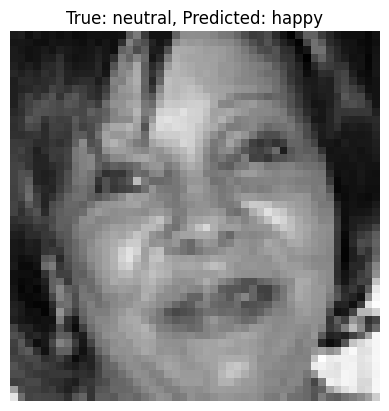

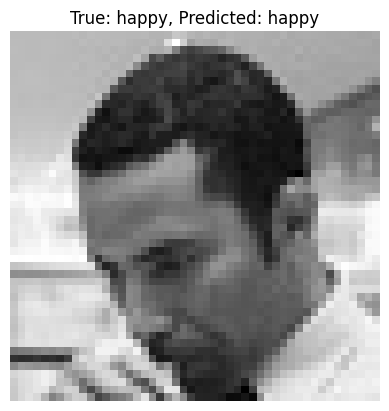

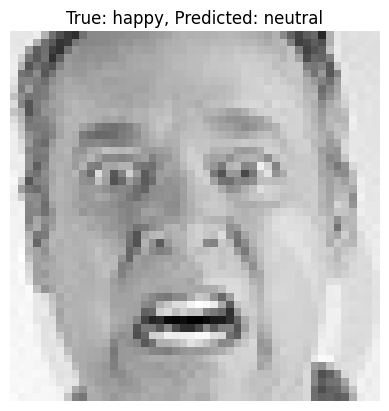

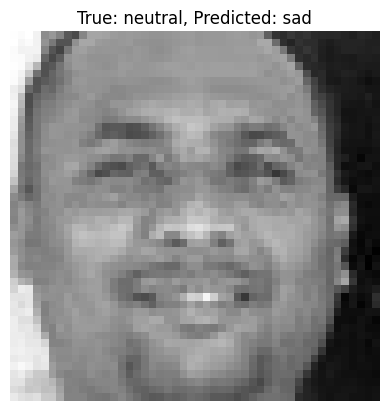

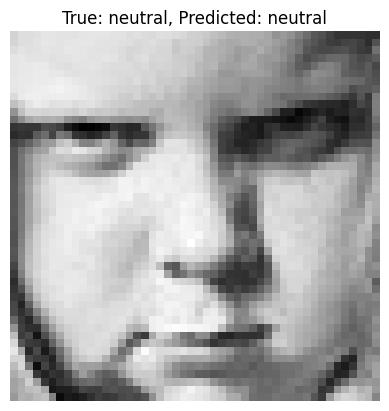

In [30]:
# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs.data, 1)
    
    random_indices = np.random.randint(0, len(y_test), 5)
    
    for idx in random_indices:
        original_image = X_original[idx].reshape(48, 48)  # Reshape to 48x48
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
        plt.show()

visualize_predictions(model, X_test_tensor, y_test_tensor, label_encoder, X_original)